In [1]:
pip install --no-build-isolation torchaudio

Note: you may need to restart the kernel to use updated packages.


In [189]:
import torchaudio
import torchaudio.transforms as transform
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import pandas as pd
import to_MLP_Utility as utl
import torch
import time


loading extracted trainning df

In [237]:
train_pt = torch.load('preprocess/dataset_separated_2s/checkpoint/contigency/complete_train.pt')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22540\3518504270.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_pt = torch.load('preprocess/dataset_separated_2s/checkp

In [238]:
val_pt = torch.load('preprocess/dataset_separated_2s/checkpoint/contigency/complete_val.pt')
test_pt = torch.load('preprocess/dataset_separated_2s/checkpoint/contigency/complete_test.pt')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22540\1132955983.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_pt = torch.load('preprocess/dataset_separated_2s/checkpoi

In [239]:
print("train: ")
print(f"Loaded {len(train_pt['features'])} samples")
print(f"First feature: {train_pt['features'][0].shape}")
print(f"First label: {train_pt['labels'][0]}")
print('-' * 40)


print("train: ")
print(f"Loaded {len(val_pt['features'])} samples")
print(f"First feature: {val_pt['features'][0].shape}")
print(f"First label: {val_pt['labels'][0]}")
print('-' * 40)


print(f"Loaded {len(test_pt['features'])} samples")
print(f"First feature: {test_pt['features'][0].shape}")
print(f"First label: {test_pt['labels'][0]}")



train: 
Loaded 13956 samples
First feature: (768,)
First label: 0
----------------------------------------
train: 
Loaded 2826 samples
First feature: (768,)
First label: 0
----------------------------------------
Loaded 1088 samples
First feature: (768,)
First label: 1


to do list:
1. create models:
- MLP (DL)
- 1 layer LSTM (ML)
- XGBoost (like that 99.3% paper) (ML)
- LightGBM
- add more
2. train models:
- train MLP dulu yg penting 
3. evaluasi:
- Accuracy (eval A)
- Precision (eval A)
- Recall (eval A)
- F1-score (eval A)
- inference speed (runtime) (eval B)
- Training time (less important but good to include) (eval B)
- Model size/complexity (eval B)
4. cari paper

What makes a good paper:
- Accuracy comparison (your MLP vs other classifiers)
- Inference speed analysis (critical for real-time detection)
- Resource usage (CPU/GPU memory - important for API deployment)

In [240]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


In [241]:
class ResearchMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout):
        super().__init__()
        layers = []
        prev_size = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            if i < len(hidden_sizes) - 1:  # Dropout on all but last layer
                layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x): 
    #    # x shape: [batch, 249, 1024]
    #    x = x.mean(dim=1)  # Average over time: [batch, 768]--> ini pooling tp td udh di pool di preprocess
        return self.network(x)  # Now output will be [batch, 1]

In [242]:
print('The Training Loop Logic\n'
'   for epoch in range(epochs):           # One full pass through data\n'
'       for batch in dataloader:          # Process in chunks (memory management)\n' \
'           1. Make predictions\n' \
'           2. Calculate how wrong they are  \n' \
'           3. Learn from mistakes (backpropagation)   \n' \
'           4. Adjust weights')

The Training Loop Logic
   for epoch in range(epochs):           # One full pass through data
       for batch in dataloader:          # Process in chunks (memory management)
           1. Make predictions
           2. Calculate how wrong they are  
           3. Learn from mistakes (backpropagation)   
           4. Adjust weights


Making object dataset

In [243]:
# Check what's actually in .pt file
print(f"Type: {type(train_pt)}")
print(f"Keys: {train_pt.keys()}")

# Access the actual data
print(f"Number of samples: {len(train_pt['features'])}")
print(f"First feature shape: {train_pt['features'][0].shape}")
print(f"First label: {train_pt['labels'][0]}")



Type: <class 'dict'>
Keys: dict_keys(['features', 'labels', 'metadata'])
Number of samples: 13956
First feature shape: (768,)
First label: 0


In [244]:
class CameraReadyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict):
        self.features = data_dict['features']  # List of tensors
        self.labels = data_dict['labels']      # List of labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx] 

In [245]:
dataset_train = CameraReadyDataset(train_pt) #--> instance
dataset_val = CameraReadyDataset(val_pt) #--> instance
dataset_test = CameraReadyDataset(test_pt) #--> instance

In [246]:
# hyperparameters
hidden_sizes = [512, 256] # --> start from the second layer, first layer is defined as input
input_size = 1024 # --> input layer
output_size = 1 # --> binary classification
dropout=0.3 # --> randomizer
epochs = 10
batch_size=100
learning_rate = 0.001


In [247]:
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True) #--> return batches (batch) of features and labels
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=True)

In [248]:
for batch in dataloader_train:
    features, labels = batch
    print(f"Features batch: {features.shape}")  # torch.Size([32, 249, 768])
    print(f"Labels batch: {labels.shape}")      # torch.Size([32])
    print(f"First 5 labels: {labels[:5]}")      # tensor([1, 0, 1, 1, 0])
    print(f"jumlah batch: {len(dataloader_train)}")
    break

print('-' * 40)

for batch in dataloader_val:
    features, labels = batch
    print(f"Features batch: {features.shape}")  # torch.Size([32, 249, 768])
    print(f"Labels batch: {labels.shape}")      # torch.Size([32])
    print(f"First 5 labels: {labels[:5]}")      # tensor([1, 0, 1, 1, 0])
    print(f"jumlah batch: {len(dataloader_val)}")
    break

print('-' * 40)

for batch in dataloader_test:
    features, labels = batch
    print(f"Features batch: {features.shape}")  # torch.Size([32, 249, 768])
    print(f"Labels batch: {labels.shape}")      # torch.Size([32])
    print(f"First 5 labels: {labels[:5]}")      # tensor([1, 0, 1, 1, 0])
    print(f"jumlah batch: {len(dataloader_test)}")
    break


Features batch: torch.Size([100, 768])
Labels batch: torch.Size([100])
First 5 labels: tensor([1, 1, 1, 1, 1])
jumlah batch: 140
----------------------------------------
Features batch: torch.Size([100, 768])
Labels batch: torch.Size([100])
First 5 labels: tensor([0, 1, 0, 1, 0])
jumlah batch: 29
----------------------------------------
Features batch: torch.Size([100, 768])
Labels batch: torch.Size([100])
First 5 labels: tensor([0, 1, 1, 0, 0])
jumlah batch: 11


In [249]:
dataset_train[0][1]

0

In [250]:
dataset_train[2][1]

1

In [251]:
for x, y in DataLoader(dataset_train, batch_size=1):
    print(x.shape)
    break
import numpy as np

torch.Size([1, 768])


In [252]:


vals = [f.mean() for f, _ in dataset_train]
print(min(vals), max(vals))
import torch
import torch.nn.functional as F

a = dataset_train[0][0]
b = dataset_train[2][0]

sim = F.cosine_similarity(torch.tensor(a), torch.tensor(b), dim=0)
print("Similarity:", sim.item())

-0.0026878184 0.004210954
Similarity: 0.7194973826408386


TRAINER AND TRAINING

In [253]:
def trainer(train_data, val_data, hidden_sizes, epochs, batch_size, learning_rate, model_type):
    #Step 1: start runtime timer
    start_time = time.perf_counter()

    # Step 2: Model
    model = model_type
    criterion = nn.BCEWithLogitsLoss() #--> loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #--> algorithm functioning to adjust the weight

    print(f"Model: Input({input_size}) -> {hidden_sizes} -> Output(1)")

    # Step 3: Training
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        model.train()

        # make batches
        dataloader_train = DataLoader(train_data, batch_size, shuffle=True) # Splits into batches of n
        dataloader_val =  DataLoader(val_data, batch_size, shuffle=True) 

        for i, batch in enumerate(dataloader_train, start=1):
            print("training for batch: ", i, '/', len(dataloader_train))
            train_features, train_labels = batch     # --> fetch X and y
            optimizer.zero_grad()                   # --> reset optimizer here
            outputs = model(train_features)         # get output by training model on X
            loss = criterion(outputs, train_labels.float().unsqueeze(1))     # calculate loss between output (binary result datas) and y (addition fixing the shape)
            
            # Calculate training accuracy (same as validation):
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            train_acc = (predictions == train_labels.unsqueeze(1)).float().mean()

            loss.backward()      # backpropagation, compute gradient of the loss
            optimizer.step()     # adjusting weight (optimizer)
        print(f'Train Acc: {train_acc.item():.4f}') 

        # keeping track and validation
        model.eval()
        dataloader_val = DataLoader(val_data, batch_size, shuffle=False)
        total_val_loss = 0
        total_val_acc = 0
        num_batches = 0
        
        with torch.no_grad():
            # initializing val dataset
            for e, batch in enumerate(dataloader_val, start=1):
                print("validation for batch: ", e, '/', len(dataloader_val))
                val_features, val_label = batch
                val_outputs = model(val_features)

                val_loss = criterion(val_outputs, val_label.float().unsqueeze(1))
                predictions = (torch.sigmoid(val_outputs) > 0.5).float()
                val_acc = (predictions == val_label.unsqueeze(1)).float().mean()
                
                total_val_loss += val_loss.item()
                total_val_acc += val_acc.item()
                num_batches += 1
        
        avg_val_loss = total_val_loss / num_batches
        avg_val_acc = total_val_acc / num_batches
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # ADD FINAL ACCURACY CALCULATION HERE:
    print("\n=== FINAL ACCURACIES ===")
    
    # Final training accuracy (across ALL training data)
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for batch in DataLoader(train_data, batch_size, shuffle=False):
            features, labels = batch
            outputs = model(features)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (predictions == labels.unsqueeze(1)).sum().item()
            train_total += labels.size(0)
    final_train_acc = train_correct / train_total
    
    # Final validation accuracy (across ALL validation data)  
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in DataLoader(val_data, batch_size, shuffle=False):
            features, labels = batch
            outputs = model(features)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (predictions == labels.unsqueeze(1)).sum().item()
            val_total += labels.size(0)
    final_val_acc = val_correct / val_total
    
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")

        
    # 3. ending runtime
    end_time = time.perf_counter()
    runtime = end_time - start_time
    return runtime, model, final_train_acc, final_val_acc 

2 LAYERED MLP

In [254]:
# hyperparameters (MLP)
hidden_sizes = [384, 192] # --> start from the second layer, first layer is defined as input
input_size = 768 # --> input layer
output_size = 1 # --> binary classification
dropout=0.5 # --> randomizer
epochs = 50
batch_size=32
learning_rate = 0.01

sample_features, sample_label = dataset_train[0] #--> load just one
input_size = sample_features.shape[0]
model = ResearchMLP(input_size, hidden_sizes, 1, dropout)

In [255]:
model

ResearchMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=384, out_features=192, bias=True)
    (4): ReLU()
    (5): Linear(in_features=192, out_features=1, bias=True)
  )
)

In [256]:
mlp_runtime, mlp_model, mlp_final_train_acc, mlp_final_val_acc =  trainer(dataset_train, dataset_val, hidden_sizes, epochs, batch_size, learning_rate, model)

Model: Input(768) -> [384, 192] -> Output(1)
training for batch:  1 / 437
training for batch:  2 / 437
training for batch:  3 / 437
training for batch:  4 / 437
training for batch:  5 / 437
training for batch:  6 / 437
training for batch:  7 / 437
training for batch:  8 / 437
training for batch:  9 / 437
training for batch:  10 / 437
training for batch:  11 / 437
training for batch:  12 / 437
training for batch:  13 / 437
training for batch:  14 / 437
training for batch:  15 / 437
training for batch:  16 / 437
training for batch:  17 / 437
training for batch:  18 / 437
training for batch:  19 / 437
training for batch:  20 / 437
training for batch:  21 / 437
training for batch:  22 / 437
training for batch:  23 / 437
training for batch:  24 / 437
training for batch:  25 / 437
training for batch:  26 / 437
training for batch:  27 / 437
training for batch:  28 / 437
training for batch:  29 / 437
training for batch:  30 / 437
training for batch:  31 / 437
training for batch:  32 / 437
trai

In [52]:
import json

# Create a Python dictionary to hold the data
data_to_save = {
    "runtime_seconds": mlp_runtime,
    "train_accuracy": mlp_final_train_acc,
    "validation_accuracy": mlp_final_val_acc,
    # For the model, we only store a string representation; 
    "model_description": str(mlp_model)
}

print(data_to_save)

with open("training result/MLP_2layer/model_results.json", "w") as f:
    json.dump(data_to_save, f, indent=4) # 'indent=4' makes the file human-readable

print("Results saved to training result/MLP_2layer/model_results.json")

# How to load it back later:
# with open("model_results.json", "r") as f:
#     loaded_data = json.load(f)
# print(loaded_data['train_accuracy'])

{'runtime_seconds': 23.214743200000157, 'train_accuracy': 0.9989566711673008, 'validation_accuracy': 0.9968299255032493, 'model_description': 'ResearchMLP(\n  (network): Sequential(\n    (0): Linear(in_features=768, out_features=384, bias=True)\n    (1): ReLU()\n    (2): Dropout(p=0.3, inplace=False)\n    (3): Linear(in_features=384, out_features=192, bias=True)\n    (4): ReLU()\n    (5): Linear(in_features=192, out_features=1, bias=True)\n  )\n)'}
Results saved to training result/MLP_2layer/model_results.json


In [53]:
# Save the trained model
torch.save(mlp_model.state_dict(), 'training result/MLP_2layer/trained_model.pth')
print("Results saved to training result/MLP_2layer/trained_model.pth")

Results saved to training result/MLP_2layer/trained_model.pth


3 LAYERED MLP

In [54]:
# hyperparameters (MLP)
hidden_sizes = [384, 192, 96] # --> start from the second layer, first layer is defined as input
input_size = 768 # --> input layer
output_size = 1 # --> binary classification
dropout=0.3 # --> randomizer
epochs = 50
batch_size=32
learning_rate = 0.001

sample_features, sample_label = dataset_train[0] #--> load just one
input_size = sample_features.shape[0]
model = ResearchMLP(input_size, hidden_sizes, 1, dropout)

In [55]:
mlp3_runtime, mlp3_model, mlp3_final_train_acc, mlp3_final_val_acc =  trainer(dataset_train, dataset_val, hidden_sizes, epochs, batch_size, learning_rate, model)

Model: Input(768) -> [384, 192, 96] -> Output(1)
training for batch:  1 / 1528
training for batch:  2 / 1528
training for batch:  3 / 1528
training for batch:  4 / 1528
training for batch:  5 / 1528
training for batch:  6 / 1528
training for batch:  7 / 1528
training for batch:  8 / 1528
training for batch:  9 / 1528
training for batch:  10 / 1528
training for batch:  11 / 1528
training for batch:  12 / 1528
training for batch:  13 / 1528
training for batch:  14 / 1528
training for batch:  15 / 1528
training for batch:  16 / 1528
training for batch:  17 / 1528
training for batch:  18 / 1528
training for batch:  19 / 1528
training for batch:  20 / 1528
training for batch:  21 / 1528
training for batch:  22 / 1528
training for batch:  23 / 1528
training for batch:  24 / 1528
training for batch:  25 / 1528
training for batch:  26 / 1528
training for batch:  27 / 1528
training for batch:  28 / 1528
training for batch:  29 / 1528
training for batch:  30 / 1528
training for batch:  31 / 1528

In [56]:
mlp3_model

ResearchMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=384, out_features=192, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=192, out_features=96, bias=True)
    (7): ReLU()
    (8): Linear(in_features=96, out_features=1, bias=True)
  )
)

In [57]:
import json

# Create a Python dictionary to hold the data
data_to_save = {
    "runtime_seconds": mlp3_runtime,
    "train_accuracy": mlp3_final_train_acc,
    "validation_accuracy": mlp3_final_val_acc,
    # For the model, we only store a string representation; 
    "model_description": str(mlp3_model)
}

print(data_to_save)

with open("training result/MLP_3layer/model_results.json", "w") as f:
    json.dump(data_to_save, f, indent=4) # 'indent=4' makes the file human-readable

print("Results saved to training result/MLP_3layer/model_results.json")

# How to load it back later:
# with open("model_results.json", "r") as f:
#     loaded_data = json.load(f)
# print(loaded_data['train_accuracy'])

{'runtime_seconds': 45.253575100000035, 'train_accuracy': 0.9981792888997996, 'validation_accuracy': 0.9963544143287367, 'model_description': 'ResearchMLP(\n  (network): Sequential(\n    (0): Linear(in_features=768, out_features=384, bias=True)\n    (1): ReLU()\n    (2): Dropout(p=0.3, inplace=False)\n    (3): Linear(in_features=384, out_features=192, bias=True)\n    (4): ReLU()\n    (5): Dropout(p=0.3, inplace=False)\n    (6): Linear(in_features=192, out_features=96, bias=True)\n    (7): ReLU()\n    (8): Linear(in_features=96, out_features=1, bias=True)\n  )\n)'}
Results saved to training result/MLP_3layer/model_results.json


In [58]:
# Save the trained model
torch.save(mlp3_model.state_dict(), 'training result/MLP_3layer/trained_model.pth')
print("Results saved to training result/MLP_3layer/trained_model.pth")

Results saved to training result/MLP_3layer/trained_model.pth


TRAIN 4 HIDDEN LAYERS

In [59]:
# hyperparameters (MLP)
# DIBAGI 5 --> 4/5
hidden_sizes = [512, 384, 256, 128] # --> start from the second layer, first layer is defined as input
input_size = 768 # --> input layer
output_size = 1 # --> binary classification
dropout=0.3 # --> randomizer
epochs = 50
batch_size=32
learning_rate = 0.001

sample_features, sample_label = dataset_train[0] #--> load just one
input_size = sample_features.shape[0]
model = ResearchMLP(input_size, hidden_sizes, 1, dropout)

In [60]:
model

ResearchMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=384, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=384, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [61]:
mlp4_runtime, mlp4_model, mlp4_final_train_acc, mlp4_final_val_acc =  trainer(dataset_train, dataset_val, hidden_sizes, epochs, batch_size, learning_rate, model)

Model: Input(768) -> [512, 384, 256, 128] -> Output(1)
training for batch:  1 / 1528
training for batch:  2 / 1528
training for batch:  3 / 1528
training for batch:  4 / 1528
training for batch:  5 / 1528
training for batch:  6 / 1528
training for batch:  7 / 1528
training for batch:  8 / 1528
training for batch:  9 / 1528
training for batch:  10 / 1528
training for batch:  11 / 1528
training for batch:  12 / 1528
training for batch:  13 / 1528
training for batch:  14 / 1528
training for batch:  15 / 1528
training for batch:  16 / 1528
training for batch:  17 / 1528
training for batch:  18 / 1528
training for batch:  19 / 1528
training for batch:  20 / 1528
training for batch:  21 / 1528
training for batch:  22 / 1528
training for batch:  23 / 1528
training for batch:  24 / 1528
training for batch:  25 / 1528
training for batch:  26 / 1528
training for batch:  27 / 1528
training for batch:  28 / 1528
training for batch:  29 / 1528
training for batch:  30 / 1528
training for batch:  31 

In [62]:
import json

# Create a Python dictionary to hold the data
data_to_save = {
    "runtime_seconds": mlp4_runtime,
    "train_accuracy": mlp4_final_train_acc,
    "validation_accuracy": mlp4_final_val_acc,
    # For the model, we only store a string representation; 
    "model_description": str(mlp4_model)
}

print(data_to_save)

with open("training result/MLP_4layer/model_results.json", "w") as f:
    json.dump(data_to_save, f, indent=4) # 'indent=4' makes the file human-readable

print("Results saved to training result/MLP_4layer/model_results.json")

# How to load it back later:
# with open("model_results.json", "r") as f:
#     loaded_data = json.load(f)
# print(loaded_data['train_accuracy'])

{'runtime_seconds': 161.86130230000026, 'train_accuracy': 0.9980360869031545, 'validation_accuracy': 0.9958789031542241, 'model_description': 'ResearchMLP(\n  (network): Sequential(\n    (0): Linear(in_features=768, out_features=512, bias=True)\n    (1): ReLU()\n    (2): Dropout(p=0.3, inplace=False)\n    (3): Linear(in_features=512, out_features=384, bias=True)\n    (4): ReLU()\n    (5): Dropout(p=0.3, inplace=False)\n    (6): Linear(in_features=384, out_features=256, bias=True)\n    (7): ReLU()\n    (8): Dropout(p=0.3, inplace=False)\n    (9): Linear(in_features=256, out_features=128, bias=True)\n    (10): ReLU()\n    (11): Linear(in_features=128, out_features=1, bias=True)\n  )\n)'}
Results saved to training result/MLP_4layer/model_results.json


In [63]:
# Save the trained model
torch.save(mlp4_model.state_dict(), 'training result/MLP_4layer/trained_model.pth')
print("Results saved to training result/MLP_4layer/trained_model.pth")

Results saved to training result/MLP_4layer/trained_model.pth


TRAIN 5 HIDDEN LAYERS

In [64]:
# hyperparameters (MLP)
# DIBAGI 6 --> 5/6, 4/6, 3/6, 2/6, 1/6
hidden_sizes = [640, 512, 384, 256, 128] # --> start from the second layer, first layer is defined as input
input_size = 768 # --> input layer
output_size = 1 # --> binary classification
dropout=0.3 # --> randomizer
epochs = 50
batch_size=32
learning_rate = 0.001

sample_features, sample_label = dataset_train[0] #--> load just one
input_size = sample_features.shape[0]
model = ResearchMLP(input_size, hidden_sizes, 1, dropout)

In [65]:
model

ResearchMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=640, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=640, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=384, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=384, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [66]:
mlp5_runtime, mlp5_model, mlp5_final_train_acc, mlp5_final_val_acc =  trainer(dataset_train, dataset_val, hidden_sizes, epochs, batch_size, learning_rate, model)

Model: Input(768) -> [640, 512, 384, 256, 128] -> Output(1)
training for batch:  1 / 1528
training for batch:  2 / 1528
training for batch:  3 / 1528
training for batch:  4 / 1528
training for batch:  5 / 1528
training for batch:  6 / 1528
training for batch:  7 / 1528
training for batch:  8 / 1528
training for batch:  9 / 1528
training for batch:  10 / 1528
training for batch:  11 / 1528
training for batch:  12 / 1528
training for batch:  13 / 1528
training for batch:  14 / 1528
training for batch:  15 / 1528
training for batch:  16 / 1528
training for batch:  17 / 1528
training for batch:  18 / 1528
training for batch:  19 / 1528
training for batch:  20 / 1528
training for batch:  21 / 1528
training for batch:  22 / 1528
training for batch:  23 / 1528
training for batch:  24 / 1528
training for batch:  25 / 1528
training for batch:  26 / 1528
training for batch:  27 / 1528
training for batch:  28 / 1528
training for batch:  29 / 1528
training for batch:  30 / 1528
training for batch:

In [67]:
import json

# Create a Python dictionary to hold the data
data_to_save = {
    "runtime_seconds": mlp5_runtime,
    "train_accuracy": mlp5_final_train_acc,
    "validation_accuracy": mlp5_final_val_acc,
    # For the model, we only store a string representation; 
    "model_description": str(mlp5_model)
}

print(data_to_save)

with open("training result/MLP_5layer/model_results.json", "w") as f:
    json.dump(data_to_save, f, indent=4) # 'indent=4' makes the file human-readable

print("Results saved to training result/MLP_5layer/model_results.json")

# How to load it back later:
# with open("model_results.json", "r") as f:
#     loaded_data = json.load(f)
# print(loaded_data['train_accuracy'])

{'runtime_seconds': 69.23525289999998, 'train_accuracy': 0.9907327850742604, 'validation_accuracy': 0.9820890790933587, 'model_description': 'ResearchMLP(\n  (network): Sequential(\n    (0): Linear(in_features=768, out_features=640, bias=True)\n    (1): ReLU()\n    (2): Dropout(p=0.3, inplace=False)\n    (3): Linear(in_features=640, out_features=512, bias=True)\n    (4): ReLU()\n    (5): Dropout(p=0.3, inplace=False)\n    (6): Linear(in_features=512, out_features=384, bias=True)\n    (7): ReLU()\n    (8): Dropout(p=0.3, inplace=False)\n    (9): Linear(in_features=384, out_features=256, bias=True)\n    (10): ReLU()\n    (11): Dropout(p=0.3, inplace=False)\n    (12): Linear(in_features=256, out_features=128, bias=True)\n    (13): ReLU()\n    (14): Linear(in_features=128, out_features=1, bias=True)\n  )\n)'}
Results saved to training result/MLP_5layer/model_results.json


In [68]:
# Save the trained model
torch.save(mlp5_model.state_dict(), 'training result/MLP_5layer/trained_model.pth')
print("Results saved to training result/MLP_5layer/trained_model.pth")

Results saved to training result/MLP_5layer/trained_model.pth


MLP train eval

In [69]:
with open("training result/MLP_2layer/model_results.json", "r") as f:
    mlp2 = json.load(f)

with open("training result/MLP_3layer/model_results.json", "r") as f:
    mlp3 = json.load(f)

with open("training result/MLP_4layer/model_results.json", "r") as f:
    mlp4 = json.load(f)

with open("training result/MLP_5layer/model_results.json", "r") as f:
    mlp5 = json.load(f)



In [72]:
model_name = ['mlp2', 'mlp3', 'mlp4', 'mlp5']
hidden_layer_count = [2, 3, 4, 5]

# epoch liat di log
stopping_epoch = [7, 13, 24, 9]


mlps = [
    mlp2,
    mlp3,
    mlp4,
    mlp5
]

mlps_df = pd.DataFrame(mlps)

#insert new column(model names and epoch number) at index 0 (first column)
mlps_df.insert(0, 'mlp_type', model_name)
mlps_df.insert(4, 'stopping_epoch', stopping_epoch)
mlps_df.insert(1, 'hidden_layer', hidden_layer_count)
mlps_df

mlp_type  hidden_layer  runtime_seconds  train_accuracy  \
0     mlp2             2        23.214743        0.998957   
1     mlp3             3        45.253575        0.998179   
2     mlp4             4       161.861302        0.998036   
3     mlp5             5        69.235253        0.990733   

   validation_accuracy  stopping_epoch  \
0             0.996830               7   
1             0.996354              13   
2             0.995879              24   
3             0.982089               9   

                                   model_description  
0  ResearchMLP(\n  (network): Sequential(\n    (0...  
1  ResearchMLP(\n  (network): Sequential(\n    (0...  
2  ResearchMLP(\n  (network): Sequential(\n    (0...  
3  ResearchMLP(\n  (network): Sequential(\n    (0...

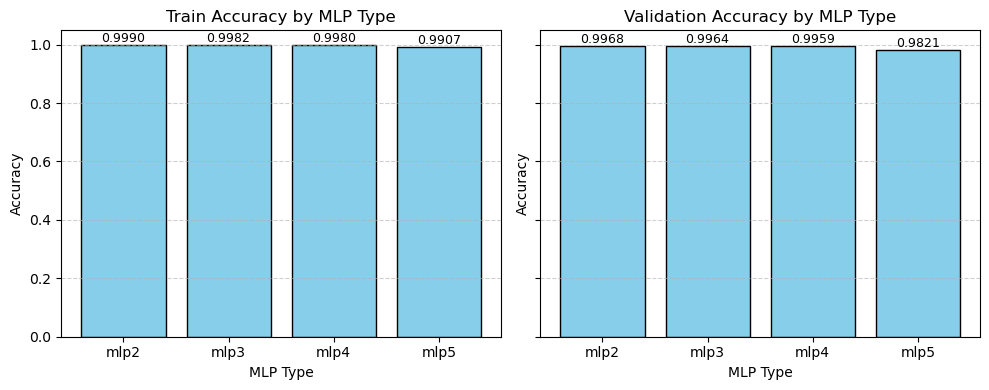

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

metrics = ['train_accuracy', 'validation_accuracy']
titles = ['Train Accuracy by MLP Type', 'Validation Accuracy by MLP Type']

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(mlps_df['mlp_type'], mlps_df[metric], color='skyblue', edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel('MLP Type')
    ax.set_ylabel('Accuracy')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # add labels on top of bars
    for j, v in enumerate(mlps_df[metric]):
        ax.text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

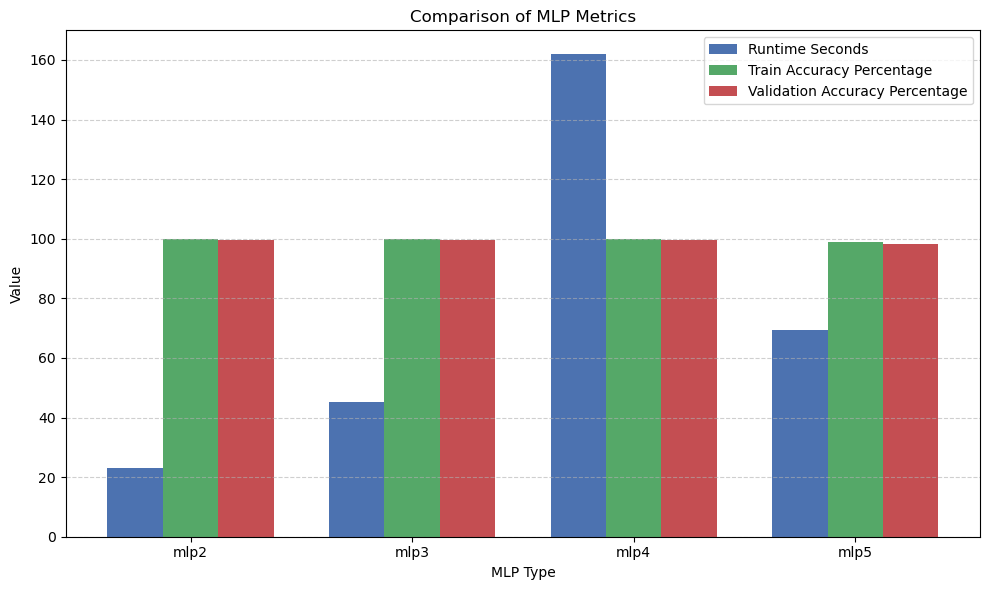

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

#convert tp percentage
mlps_df['train_accuracy_percentage'] = mlps_df['train_accuracy'] * 100
mlps_df['validation_accuracy_percentage'] = mlps_df['validation_accuracy'] * 100

# choose metric to visualize — change this to what you want
metrics = ['runtime_seconds', 'train_accuracy_percentage', 'validation_accuracy_percentage']    # options: 'runtime_seconds', 'train_accuracy', etc.
colors = ['#4C72B0', '#55A868', '#C44E52']

x = np.arange(len(mlps_df['mlp_type']))  # x positions for groups
bar_width = 0.25                    # width of each bar

plt.figure(figsize=(10, 6))

# plot each metric
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, mlps_df[metric], width=bar_width, color=colors[i],
            label=metric.replace('_', ' ').title())

# labels and formatting
plt.xlabel('MLP Type')
plt.ylabel('Value')
plt.title('Comparison of MLP Metrics')
plt.xticks(x + bar_width, mlps_df['mlp_type'])  # center tick labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


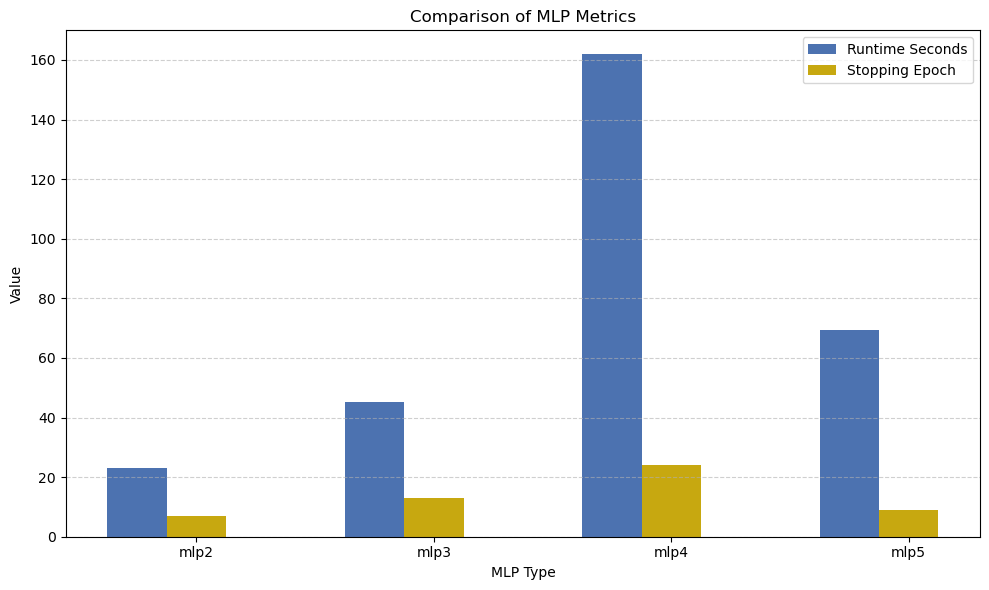

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# choose metric to visualize — change this to what you want
metrics = ['runtime_seconds', 'stopping_epoch']    # options: 'runtime_seconds', 'train_accuracy', etc.
colors = ['#4C72B0', "#C7A810"]

x = np.arange(len(mlps_df['mlp_type']))  # x positions for groups
bar_width = 0.25                    # width of each bar

plt.figure(figsize=(10, 6))

# plot each metric
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, mlps_df[metric], width=bar_width, color=colors[i],
            label=metric.replace('_', ' ').title())

# labels and formatting
plt.xlabel('MLP Type')
plt.ylabel('Value')
plt.title('Comparison of MLP Metrics')
plt.xticks(x + bar_width, mlps_df['mlp_type'])  # center tick labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


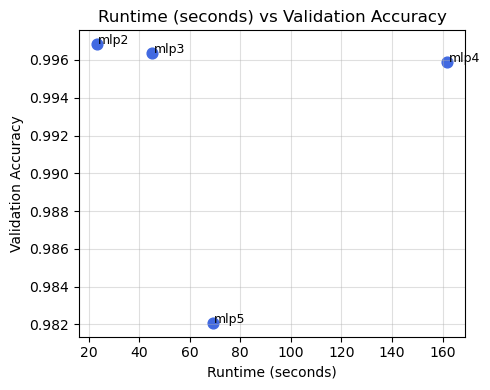

In [79]:
#Runtime vs Accuracy


# --- 1. Runtime vs Validation Accuracy ---
plt.figure(figsize=(5,4))

plt.scatter(mlps_df['runtime_seconds'], mlps_df['validation_accuracy'], color='royalblue', s=60)

# add labels for each point
for i, txt in enumerate(mlps_df['mlp_type']):
    plt.text(mlps_df['runtime_seconds'][i]+0.5, mlps_df['validation_accuracy'][i], txt, fontsize=9)

plt.title('Runtime (seconds) vs Validation Accuracy')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Validation Accuracy')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

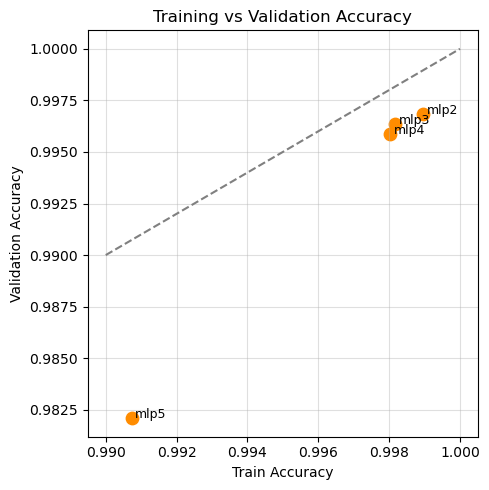

In [80]:
plt.figure(figsize=(5,5))
plt.scatter(mlps_df['train_accuracy'], mlps_df['validation_accuracy'], color='darkorange', s=80)

# diagonal line (perfect generalization)
plt.plot([0.99, 1.0], [0.99, 1.0], color='gray', linestyle='--')

for i, txt in enumerate(mlps_df['mlp_type']):
    plt.text(mlps_df['train_accuracy'][i]+0.0001, mlps_df['validation_accuracy'][i], txt, fontsize=9)

plt.title('Training vs Validation Accuracy')
plt.xlabel('Train Accuracy')
plt.ylabel('Validation Accuracy')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


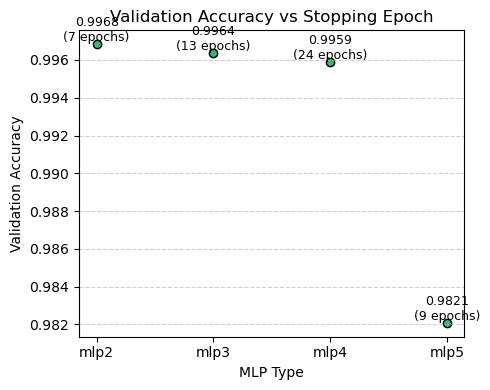

In [81]:
plt.figure(figsize=(5,4))
plt.scatter(mlps_df['mlp_type'], mlps_df['validation_accuracy'], color='mediumseagreen', edgecolor='black')

# annotate with epoch numbers
for i, v in enumerate(mlps_df['validation_accuracy']):
    plt.text(i, v, f'{v:.4f}\n({mlps_df["stopping_epoch"][i]} epochs)', ha='center', va='bottom', fontsize=9)

plt.title('Validation Accuracy vs Stopping Epoch')
plt.xlabel('MLP Type')
plt.ylabel('Validation Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


INFERENCE

In [170]:

# To load it for inference:
cnn_model = SimpleCNN(input_channels=768, num_classes=1)
cnn_model.load_state_dict(torch.load('training result/CNN/trained_model.pth'))
cnn_model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24812\1816241885.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load('training result/CNN/tra

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv1d(768, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): AdaptiveAvgPool1d(output_size=1)
  )
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [97]:
dropout = 0.8
# To load it later for inference:
mlp2_model = ResearchMLP(input_size=768, hidden_sizes=[384, 192], output_size=1, dropout=0.8)
mlp2_model.load_state_dict(torch.load('training result/MLP_2layer/trained_model.pth'))
mlp2_model.eval()
# To load it for inference:
mlp3_model = ResearchMLP(input_size=768, hidden_sizes=[384, 192, 96], output_size=1, dropout = dropout)
mlp3_model.load_state_dict(torch.load('training result/MLP_3layer/trained_model.pth'))
mlp3_model.eval()
# To load it for inference:
mlp4_model = ResearchMLP(input_size=768, hidden_sizes=[512, 384, 256, 128], output_size=1, dropout = dropout)
mlp4_model.load_state_dict(torch.load('training result/MLP_4layer/trained_model.pth'))
mlp4_model.eval()
# To load it for inference:
mlp5_model = ResearchMLP(input_size=768, hidden_sizes=[640, 512, 384, 256, 128], output_size=1, dropout=dropout)
mlp5_model.load_state_dict(torch.load('training result/MLP_5layer/trained_model.pth'))
mlp5_model.eval()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21536\2947902284.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp2_model.load_state_dict(torch.load('training result/MLP_2l

ResearchMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=640, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.8, inplace=False)
    (3): Linear(in_features=640, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.8, inplace=False)
    (6): Linear(in_features=512, out_features=384, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.8, inplace=False)
    (9): Linear(in_features=384, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.8, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)

ini tester perlu dibikin jadi average runtime bukan total

In [98]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def tester(model, pred_treshold):
    #start runtime
    start_time = time.perf_counter()
    
    # Ensure you're on CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():  # no gradient calculation (inference)
        for batch in dataloader_test:
            # unpack your batch (adjust if dataset returns differently)
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass --> testing only has forward pass
            outputs = model(inputs)
            
            # assuming binary classification with sigmoid output
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > pred_treshold).astype(int)  # threshold to 0/1

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)

    # --- Compute metrics ---
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # ending runtime
    end_time = time.perf_counter()
    runtime = end_time - start_time
    print(f"Runtime:  {runtime:.4f}")
    
    return acc, prec, rec, f1, runtime


In [99]:
treshold = 0.3

mlp2_acc, mlp2_prec, mlp2_rec, mlp2_f1, mlp2_runtime = tester(mlp2_model, treshold)
print('-' *40)
mlp3_acc, mlp3_prec, mlp3_rec, mlp3_f1, mlp3runtime = tester(mlp3_model, treshold)
print('-' *40)
mlp4_acc, mlp4_prec, mlp4_rec, mlp4_f1, mlp4_runtime = tester(mlp4_model, treshold)
print('-' *40)
mlp5_acc, mlp5_prec, mlp5_rec, mlp5_f1, mlp5_runtime = tester(mlp5_model, treshold)
print('-' *40)
#cnn_acc, cnn_prec, cnn_rec, cnn_f1, cnn_runtime = tester(cnn_model, treshold)

Accuracy:  0.8734
Precision: 0.9094
Recall:    0.5349
F1 Score:  0.6736
Runtime:  0.0463
----------------------------------------
Accuracy:  0.8335
Precision: 0.8240
Recall:    0.4044
F1 Score:  0.5425
Runtime:  0.0364
----------------------------------------
Accuracy:  0.8546
Precision: 0.8293
Recall:    0.5092
F1 Score:  0.6310
Runtime:  0.0423
----------------------------------------
Accuracy:  0.6836
Precision: 0.4261
Recall:    0.8529
F1 Score:  0.5683
Runtime:  0.0571
----------------------------------------


CNN

In [119]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=1):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),      # 768 → 384
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)           # → [batch, 64, 1]
        )

        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # INPUT SHAPE EXPECTED NOW:
        # x: [batch, 768]

        if x.ndim == 2:
            # (batch, 768) → (batch, 1, 768)
            x = x.unsqueeze(1)

        # If someone passes (batch, 1, 768), that's fine too.

        x = self.conv_layers(x)     # → [batch, 64, 1]
        x = x.squeeze(-1)           # → [batch, 64]
        return self.classifier(x)   # → [batch, 1]


2 BLOCK CNN

In [120]:

hidden_sizes = [384, 192] # --> start from the second layer, first layer is defined as input
input_size = 1 # --> input layer
output_size = 1 # --> binary classification
dropout=0.5 # --> randomizer
epochs = 50
batch_size=32
learning_rate = 0.001
cnn_model = SimpleCNN(input_channels=1, num_classes=1)


In [121]:
cnn_model

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): AdaptiveAvgPool1d(output_size=1)
  )
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [122]:
cnn_runtime, cnn_model, cnn_final_train_acc, cnn_final_val_acc = trainer(
    dataset_train, dataset_val, hidden_sizes, epochs, batch_size, learning_rate, model_type=cnn_model
)


Model: Input(1) -> [384, 192] -> Output(1)
training for batch:  1 / 1528
training for batch:  2 / 1528
training for batch:  3 / 1528
training for batch:  4 / 1528
training for batch:  5 / 1528
training for batch:  6 / 1528
training for batch:  7 / 1528
training for batch:  8 / 1528
training for batch:  9 / 1528
training for batch:  10 / 1528
training for batch:  11 / 1528
training for batch:  12 / 1528
training for batch:  13 / 1528
training for batch:  14 / 1528
training for batch:  15 / 1528
training for batch:  16 / 1528
training for batch:  17 / 1528
training for batch:  18 / 1528
training for batch:  19 / 1528
training for batch:  20 / 1528
training for batch:  21 / 1528
training for batch:  22 / 1528
training for batch:  23 / 1528
training for batch:  24 / 1528
training for batch:  25 / 1528
training for batch:  26 / 1528
training for batch:  27 / 1528
training for batch:  28 / 1528
training for batch:  29 / 1528
training for batch:  30 / 1528
training for batch:  31 / 1528
train

In [123]:
# Create a Python dictionary to hold the data
data_to_save = {
    "runtime_seconds": cnn_runtime,
    "train_accuracy": cnn_final_train_acc,
    "validation_accuracy": cnn_final_val_acc,
    # For the model, we only store a string representation; 
    "model_description": str(cnn_model)
}

print(data_to_save)

with open("training result/CNN/model_results.json", "w") as f:
    json.dump(data_to_save, f, indent=4) # 'indent=4' makes the file human-readable

print("Results saved to training result/CNN/model_results.json")

{'runtime_seconds': 78.11743950000073, 'train_accuracy': 0.8330878441962276, 'validation_accuracy': 0.783483911871929, 'model_description': 'SimpleCNN(\n  (conv_layers): Sequential(\n    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))\n    (1): ReLU()\n    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))\n    (4): ReLU()\n    (5): AdaptiveAvgPool1d(output_size=1)\n  )\n  (classifier): Linear(in_features=64, out_features=1, bias=True)\n)'}
Results saved to training result/CNN/model_results.json


In [124]:
# Save the trained model
torch.save(cnn_model.state_dict(), 'training result/CNN/trained_model.pth')
print("Results saved to training result/CNN/trained_model.pth")

Results saved to training result/CNN/trained_model.pth


4 block CNN

In [125]:

hidden_sizes = [512, 384, 256, 128]# --> start from the second layer, first layer is defined as input
input_size = 1 # --> input layer
output_size = 1 # --> binary classification
dropout=0.5 # --> randomizer
epochs = 50
batch_size=32
learning_rate = 0.001
cnn_model = SimpleCNN(input_channels=1, num_classes=1)


In [126]:
cnn4_runtime, cnn4_model, cnn4_final_train_acc, cnn4_final_val_acc = trainer(
    dataset_train, dataset_val, hidden_sizes, epochs, batch_size, learning_rate, model_type=cnn_model
)

Model: Input(1) -> [512, 384, 256, 128] -> Output(1)
training for batch:  1 / 1528
training for batch:  2 / 1528
training for batch:  3 / 1528
training for batch:  4 / 1528
training for batch:  5 / 1528
training for batch:  6 / 1528
training for batch:  7 / 1528
training for batch:  8 / 1528
training for batch:  9 / 1528
training for batch:  10 / 1528
training for batch:  11 / 1528
training for batch:  12 / 1528
training for batch:  13 / 1528
training for batch:  14 / 1528
training for batch:  15 / 1528
training for batch:  16 / 1528
training for batch:  17 / 1528
training for batch:  18 / 1528
training for batch:  19 / 1528
training for batch:  20 / 1528
training for batch:  21 / 1528
training for batch:  22 / 1528
training for batch:  23 / 1528
training for batch:  24 / 1528
training for batch:  25 / 1528
training for batch:  26 / 1528
training for batch:  27 / 1528
training for batch:  28 / 1528
training for batch:  29 / 1528
training for batch:  30 / 1528
training for batch:  31 / 

In [136]:
# Create a Python dictionary to hold the data
data_to_save = {
    "runtime_seconds": cnn4_runtime,
    "train_accuracy": cnn4_final_train_acc,
    "validation_accuracy": cnn4_final_val_acc,
    # For the model, we only store a string representation; 
    "model_description": str(cnn4_model)
}

print(data_to_save)

with open("training result/CNN_4block/model_results.json", "w") as f:
    json.dump(data_to_save, f, indent=4) # 'indent=4' makes the file human-readable

print("Results saved to training result/CNN_4block/model_results.json")

{'runtime_seconds': 518.7390456000003, 'train_accuracy': 0.9287876928112597, 'validation_accuracy': 0.908543350768743, 'model_description': 'SimpleCNN(\n  (conv_layers): Sequential(\n    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))\n    (1): ReLU()\n    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))\n    (4): ReLU()\n    (5): AdaptiveAvgPool1d(output_size=1)\n  )\n  (classifier): Linear(in_features=64, out_features=1, bias=True)\n)'}
Results saved to training result/CNN_4block/model_results.json


In [140]:
# Save the trained model
torch.save(cnn4_model.state_dict(), 'training result/CNN_4block/trained_model.pth')
print("Results saved to training result/CNN_4block/trained_model.pth")

Results saved to training result/CNN_4block/trained_model.pth


INFERENCE CNN

In [150]:
# 2 block
treshold = 0.99
# To load it for inference:
cnn2 = SimpleCNN(input_channels=1, num_classes=1)
cnn2.load_state_dict(torch.load('training result/CNN/trained_model.pth'))
cnn2.eval()
cnn2_acc, cnn2_prec, cnn2_rec, cnn2_f1, cnn2_runtime = tester(cnn2, treshold)

Accuracy:  0.7558
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
Runtime:  0.2012


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21536\277281516.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn2.load_state_dict(torch.load('training result/CNN/trained_m

In [ ]:
#4block

treshold = 0.5

# To load it for inference:
cnn4 = SimpleCNN(input_channels=1, num_classes=1)
cnn4.load_state_dict(torch.load('training result/CNN_4block/trained_model.pth'))
cnn4.eval()
cnn4_acc, cnn4_prec, cnn4_rec, cnn4_f1, cnn4_runtime = tester(cnn4, treshold)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21536\3278753602.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn4.load_state_dict(torch.load('training result/CNN_4block/t

Accuracy:  0.2769
Precision: 0.2478
Recall:    0.9632
F1 Score:  0.3941
Runtime:  0.2060


XGBoost

In [71]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [72]:
for batch in DataLoader(dataset_train, batch_size, shuffle=True):
            X_train, y_train = batch

for batch in DataLoader(dataset_test, batch_size, shuffle=True):
            X_test, y_test = batch

#creating dmatrix object: The DMatrix separates features from the target variable (label)
train_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [73]:
import numpy as np
print(np.unique(y_train))


[0 1]


In [74]:
#hyperparameter

params = {'objective':'binary:logistic',
          'max_depth':3,
          'learning_rate':0.1,
          'eval_metric':'error'}
          
num_round = 50

In [75]:
#runtime start
start_time = time.perf_counter()

#drop model here
model = xgb.train(params, train_dmatrix, num_round)

# ending runtime
end_time = time.perf_counter()
runtime = end_time - start_time
print(f"Runtime:  {runtime:.4f}")

Runtime:  7.4031


In [76]:
test_dmatrix = xgb.DMatrix(data=X_test)

In [77]:
#runtime start
start_time = time.perf_counter()

y_pred = model.predict(test_dmatrix)
y_pred = [round(value) for value in y_pred]

# ending runtime
end_time = time.perf_counter()
runtime = end_time - start_time
print(f"Runtime:  {runtime:.4f}")

Runtime:  0.0519


In [78]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 51.14%


In [79]:
# --- Compute metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Runtime:  {runtime:.4f}")

NameError: name 'precision_score' is not defined

In [ ]:
""